### Berth allocation problem

1910101

In [232]:
import pandas as pd
import numpy as np
import operator
from dataclasses import dataclass
import matplotlib.pyplot as plt
from matplotlib import colors
from time import time
import math

@dataclass()
class Node:
    time: int         # time axis -- rename needed
    pos: int          # position axis
    cls: np.array     # type: ignore

    def __eq__(self, other):
        return self.time == other.time and self.pos == other.pos and np.array_equal(self.cls, other.cls)

    def __key(self):
        return (self.time, self.pos, str(list(self.cls)))

    def __hash__(self):
        return hash(self.__key())

    def __str__(self):
        return "{ %d, %d, %s }" % (self.time, self.pos, 'lower' if self.cls[0] == 1 else 'upper')


Import the input

In [233]:
with open('input1.txt', 'r') as file:
    infos = file.read().split("\n\n")
    berth_len = int(infos[0].split("\n")[1])
    berth_breaks_list = [int(x) for x in infos[1].split("\n")[1:]]
    vessels_list = [line.split("\t") for line in infos[2].split("\n")[1:-1]]

print(f"""Berth len: {berth_len}
Berth breaks: {berth_breaks_list}""")


vessels_df = pd.DataFrame.from_dict({
    "vessel_idx": [i for i in range(1, len(vessels_list) + 1)],
    "size_": [int(v[1]) for v in vessels_list],
    "t_arrive": [int(v[2]) for v in vessels_list],
    "t_process": [int(v[3]) for v in vessels_list],
    "weight": [int(v[4]) if len(v) == 5 else 1 for v in vessels_list],
})
print(vessels_df)

Berth len: 40
Berth breaks: [20, 32]
    vessel_idx  size_  t_arrive  t_process  weight
0            1     10        10         10       1
1            2     15         5          9       2
2            3      6         0          5       1
3            4     20         2         10       3
4            5      5        15          5       1
5            6     15        12          8       1
6            7      7         8         10       3
7            8     10        10         10       1
8            9     15         5          9       2
9           10      6         0          5       1
10          11     20         2         10       3
11          12      5        15          5       1
12          13     15        12          8       1
13          14     10        10         10       1
14          15     15         5          9       2
15          16      6         0          5       1
16          17     20         2         10       3
17          18      5        15          5   

Construction phase  
  1. Input the packing of previous `n-1` vessels and (size, t_arrive, t_process) of vessel `n` 
  2. Classify nodes within ABCD to 5 classes, turn `[1,0,1,0]` and `[0,1,0,1]` nodes into Class1's
  3. Group C1 = `[1,0,0,0]` and `[0,0,0,1]` nodes, C3 = Class3 nodes
  4. Extend nodes in C3 to edges of the hole, add intersections to I1 and I2, update I1 and I2 vectors accordingly
  5. Test feasibility & optimality in C1 + I1 + I2 nodes
     
Assume that there are `k` feasible positions, calculate Cost = sum(w(c - a)) for each position, filter "bad" positions relative to others. 
    
After screening, use a probability to choose the berth position among the candidates.

In [234]:
TIME_HORIZON = sum(vessels_df.t_process)
ABCD_right = TIME_HORIZON
ABCD_top = berth_len
ABCD_bot = 0

def generate_packing(sorted_df, log=True):

    packing = pd.DataFrame.from_dict({
        "vessel_idx": [0 for _ in range(len(berth_breaks_list))],
        "t_moore": [0 for _ in range(len(berth_breaks_list))],
        "t_finish": [TIME_HORIZON for _ in range(len(berth_breaks_list))],
        "p_start": [pos for pos in berth_breaks_list],
        "p_end": [pos for pos in berth_breaks_list]
    })

    # Take packing info and current vessel info
    for row in sorted_df.index:
        vessel = sorted_df.loc[row]
        if log: print(f"🛳️Vessel_{vessel.vessel_idx}, 📏{vessel.size_}, ⏱️{vessel.t_arrive}~{vessel.t_process}.")

        # If this cut through a block then it is a moore point
        ABCD_left = vessel.t_arrive

        # Set of vertical and horizontal lines to construct grid
        verticals = set([ABCD_left, ABCD_right])
        horizontals = set([ABCD_bot, ABCD_top])
        
        v_blobs = []
        h_blobs = []

        # Construct grid
        for idx in packing.index:
            rect = packing.loc[idx]
            if rect.t_finish > ABCD_left:
                verticals.add(rect.t_finish)
                horizontals.add(rect.p_start)  # type: ignore
                horizontals.add(rect.p_end)  # type: ignore

                h_blobs.append((rect.p_start, rect.p_end))
                v_blobs.append((max([rect.t_moore, ABCD_left]), rect.t_finish))  # type: ignore

            if rect.t_moore > ABCD_left:
                verticals.add(rect.t_moore)

        # Classify nodes
        t_moore_s = list(set(packing.t_moore.add(ABCD_left)))
        t_moore_s.sort() 
        t_finish_es = list(set(packing.t_finish))
        t_finish_es.sort() 
        p_start_s = list(set(packing.p_start))
        p_start_s.sort() 
        p_end_s = list(set(packing.p_end))
        p_end_s.sort() 
        nodes = []
        for time in verticals:
            for pos in horizontals:
                new_node = Node(time, pos, np.array([1, 1, 1, 1])) # type: ignore
                walls = np.array([
                    time in t_moore_s and pos in p_start_s and pos not in p_end_s or time >= ABCD_right or pos >= ABCD_top,
                    time in t_finish_es and pos in p_start_s or time <= ABCD_left or pos >= ABCD_top,
                    time in t_finish_es and pos in p_end_s or time <= ABCD_left or pos <= ABCD_bot,
                    time in t_moore_s and pos in p_end_s or time >= ABCD_right or pos <= ABCD_bot
                ])
                new_node.cls -= walls
                
                # Add missing vincinities
                v_overlap = list(filter(lambda bounds: bounds[1][0] <= time and time <= bounds[1][1], enumerate(v_blobs)))
                h_overlap = [h_blobs[i] for i,_ in v_overlap]
                v_overlap = [v for _,v in v_overlap]
                for vb, hb in zip(v_overlap, h_overlap):
                    if hb[0] > pos or pos > hb[1]:
                        continue
                    vin = np.array([
                        not(time < vb[1] and pos < hb[1]),
                        not(time > vb[0] and pos < hb[1]),
                        not(time > vb[0] and pos > hb[0]),
                        not(time > vb[1] and pos > hb[0]),
                    ])
                    new_node.cls *= vin

                # Turn Class 2 node into Class 1 nodes
                if np.array_equal(new_node.cls, np.array([1,0,1,0])):
                    nodes.append(Node(new_node.time, new_node.pos, np.array([1,0,0,0])))
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,0,1,0])))
                elif np.array_equal(new_node.cls, np.array([0,1,0,1])):
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,1,0,0])))
                    nodes.append(Node(new_node.time, new_node.pos, np.array([0,0,0,1])))
                else:
                    nodes.append(new_node)


        # Grouping nodes to form a list of possible corner to stuck the next vessel in
        C1 = list(filter(
            lambda node: np.array_equal(node.cls, [1,0,0,0]) or np.array_equal(node.cls, [0,0,0,1]), nodes))
        C3 = list(filter(lambda node: np.sum(node.cls) == 3, nodes))
        I1 = []
        for node in C3:
            if node.cls[0] == 0:
                ## Extend leftwards
                same_pos_nodes = list(filter(lambda n: n.pos == node.pos, nodes))
                same_pos_nodes.sort(key=operator.attrgetter("time"), reverse=True)
                ## Get the first node that is not a Class4 (empty space) node
                extended = next(filter(lambda n: n.time < node.time and sum(n.cls) != 4, same_pos_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([0,0,0,1])))
            
            elif node.cls[3] == 0:
                ## Extend leftwards
                same_pos_nodes = list(filter(lambda n: n.pos == node.pos, nodes))
                same_pos_nodes.sort(key=operator.attrgetter("time"), reverse=True)
                extended = next(filter(lambda n: n.time < node.time and sum(n.cls) != 4, same_pos_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([1,0,0,0])))

            elif node.cls[1] == 0:
                ## Extend downwards
                same_time_nodes = list(filter(lambda n: n.time == node.time, nodes))
                same_time_nodes.sort(key=operator.attrgetter("pos"), reverse=True)
                extended = next(filter(lambda n: n.pos < node.pos and sum(n.cls) != 4, same_time_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([1,0,0,0])))

            else:
                ## Extend upwards
                same_time_nodes = list(filter(lambda n: n.time == node.time, nodes))
                same_time_nodes.sort(key=operator.attrgetter("pos"))
                extended = next(filter(lambda n: n.pos > node.pos and sum(n.cls) != 4, same_time_nodes))
                I1.append(Node(extended.time, extended.pos, np.array([0,0,0,1])))
        

        # Intersections of lines in I1, can defer this and do this later
        I2 = [] 
        POSSIBLE = list(set(I1 + C1))


        # Test feasibility
        pruned_list = []
        for position in POSSIBLE:
            time_range = (position.time, position.time + vessel.t_process)
            pos_range = (position.pos, position.pos + vessel.size_) if position.cls[0] else \
                        (position.pos - vessel.size_, position.pos)
            if pos_range[1] > berth_len or pos_range[0] < 0:
                continue
            # Check if this range overlap any blobs
            idx_v_overlap = list(filter(lambda bounds: bounds[1][0] < time_range[1] and time_range[0] < bounds[1][1], enumerate(v_blobs)))
            h_ = [h_blobs[i] for i, _ in idx_v_overlap]
            h_overlap = list(filter(lambda bounds: bounds[0] < pos_range[1] and pos_range[0] < bounds[1], h_))
            v_overlap = [v for _, v in idx_v_overlap]
            if len(h_overlap) != 0:
                # print(f"{position} overlap with {h_overlap}, {v_overlap}")
                pass
            else:
                pruned_list.append(position)
        POSSIBLE = pruned_list

        # Test optimality: for same positions and class, nodes that starts sooner is better
                   


        # # Calculate cost of the above positions by makespan
        # makespans = []
        # for position in POSSIBLE:
        #     if len(packing.t_finish) == len(berth_breaks_list):
        #         break
        #     this_t_finish = packing.t_finish[len(berth_breaks_list):].copy() + [position.time + vessel.t_process]
        #     makespans.append(max(sorted_df.weight[:len(this_t_finish)] * np.array(this_t_finish)))
        # min_pos = np.argmin(makespans) if len(makespans) else 0

        # Calculate cost of the above positions by wait time
        waits = []
        padding = len(berth_breaks_list)
        POSSIBLE.sort(key=operator.attrgetter("pos"))
        for position in POSSIBLE:
            if len(packing.t_finish) == padding:
                break
            this_t_wait = (packing.t_finish[padding:] - packing.t_moore[padding:]).copy() + [position.time - vessel.t_arrive]
            waits.append(sum(sorted_df.weight[:len(this_t_wait)] * np.array(this_t_wait)))
        min_pos = np.argmin(waits) if len(waits) else 0


        # Filter worse positions
        # Choose one position acc. to a probability

        if len(POSSIBLE) == 0:
            print("No solution can be found!!!")
            return None, None

        position = POSSIBLE[min_pos]
        packing.loc[len(packing.index)] = [  # type: ignore
            vessel.vessel_idx,
            position.time, 
            position.time + vessel.t_process, 
            position.pos if position.cls[0] else position.pos - vessel.size_,
            position.pos + vessel.size_ if position.cls[0] else position.pos
        ]

        result = packing.tail(1)
        if log: 
            print(f"⚓Vessel_{row}, 📌{int(result.p_start)}-{int(result.p_end)}, ⌛{int(result.t_moore)}-{int(result.t_finish)}.")
            print("")

        # print("💡Positions: " + ",".join([str(p) for p in POSSIBLE]))
        # print(nodes)
        # print("💡Possible positions: ", POSSIBLE)
        # print(C1, C3)
    
    if log: 
        print("Makespan: ", max(packing.t_finish[padding:]))
        print("Weighted makespan: ", max(np.array(sorted_df.weight) * np.array(packing.t_finish[len(berth_breaks_list):])))
        print("Weighted wait time: ", waits[min_pos])

    return packing, waits[min_pos]


In [235]:
sorted_df = vessels_df.sort_values(by=['t_arrive'])
print(sorted_df)

    vessel_idx  size_  t_arrive  t_process  weight
21          22      6         0          5       1
2            3      6         0          5       1
27          28      6         0          5       1
39          40      6         0          5       1
15          16      6         0          5       1
33          34      6         0          5       1
9           10      6         0          5       1
22          23     20         2         10       3
28          29     20         2         10       3
16          17     20         2         10       3
34          35     20         2         10       3
40          41     20         2         10       3
3            4     20         2         10       3
10          11     20         2         10       3
26          27     15         5          9       2
8            9     15         5          9       2
14          15     15         5          9       2
38          39     15         5          9       2
32          33     15         5

In [236]:
t1 = time()
# The original sorted df
res, score = generate_packing(sorted_df, log=True)
other_packings = [(res, score)]

# Swap adjacent ships to best preserve ordering
for index in range(len(vessels_df) - 1):
    new_df = pd.DataFrame.from_records(sorted_df)
    r1, r2 = new_df.iloc[index].copy(), new_df.iloc[index + 1].copy()
    new_df.iloc[index], new_df.iloc[index + 1] = r2, r1

    result, score = generate_packing(new_df, log=False)
    other_packings.append((result, score))

t2 = time()

🛳️Vessel_22, 📏6, ⏱️0~5.
⚓Vessel_21, 📌0-6, ⌛0-5.

🛳️Vessel_3, 📏6, ⏱️0~5.
⚓Vessel_2, 📌6-12, ⌛0-5.

🛳️Vessel_28, 📏6, ⏱️0~5.
⚓Vessel_27, 📌12-18, ⌛0-5.

🛳️Vessel_40, 📏6, ⏱️0~5.
⚓Vessel_39, 📌20-26, ⌛0-5.

🛳️Vessel_16, 📏6, ⏱️0~5.
⚓Vessel_15, 📌26-32, ⌛0-5.

🛳️Vessel_34, 📏6, ⏱️0~5.
⚓Vessel_33, 📌32-38, ⌛0-5.

🛳️Vessel_10, 📏6, ⏱️0~5.
⚓Vessel_9, 📌0-6, ⌛5-10.

🛳️Vessel_23, 📏20, ⏱️2~10.
⚓Vessel_22, 📌0-20, ⌛10-20.

🛳️Vessel_29, 📏20, ⏱️2~10.
⚓Vessel_28, 📌0-20, ⌛20-30.

🛳️Vessel_17, 📏20, ⏱️2~10.
⚓Vessel_16, 📌0-20, ⌛30-40.

🛳️Vessel_35, 📏20, ⏱️2~10.
⚓Vessel_34, 📌0-20, ⌛40-50.

🛳️Vessel_41, 📏20, ⏱️2~10.
⚓Vessel_40, 📌0-20, ⌛50-60.

🛳️Vessel_4, 📏20, ⏱️2~10.
⚓Vessel_3, 📌0-20, ⌛60-70.

🛳️Vessel_11, 📏20, ⏱️2~10.
⚓Vessel_10, 📌0-20, ⌛70-80.

🛳️Vessel_27, 📏15, ⏱️5~9.
⚓Vessel_26, 📌0-15, ⌛80-89.

🛳️Vessel_9, 📏15, ⏱️5~9.
⚓Vessel_8, 📌0-15, ⌛89-98.

🛳️Vessel_15, 📏15, ⏱️5~9.
⚓Vessel_14, 📌0-15, ⌛98-107.

🛳️Vessel_39, 📏15, ⏱️5~9.
⚓Vessel_38, 📌0-15, ⌛107-116.

🛳️Vessel_33, 📏15, ⏱️5~9.
⚓Vessel_32, 📌0-15, ⌛116-125.

🛳️Vess

In [237]:
min_wait = np.argmin([t if t is not None else math.inf for (_, t) in other_packings])
print(f"Heuristic finished in {t2 - t1} secs.")
print(f"Min wait time: {other_packings[min_wait][1]}")

Heuristic finished in 46.41859006881714 secs.
Min wait time: 2507


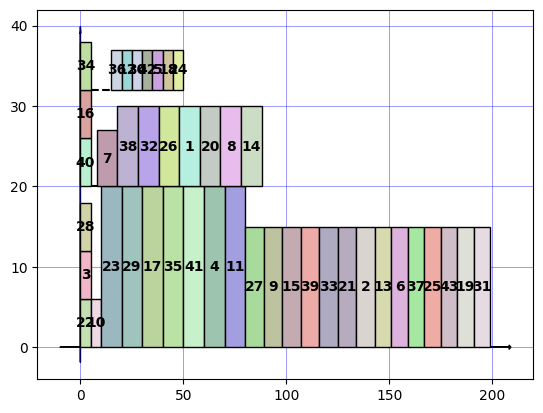

In [238]:
### TUAN QM VIS.

# Draw plot
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111)

# Grid
grid(color='b', linestyle='-', linewidth=0.7, alpha=0.4)

# Bright color
low = 0.6
high = 0.95
for i in other_packings[min_wait][0].index:
	row = other_packings[min_wait][0].loc[i]
	if row.vessel_idx == 0:
		continue
	rgb = (np.random.uniform(low=low, high=high),
		   np.random.uniform(low=low, high=high),
		   np.random.uniform(low=low, high=high))
	rect=mpatches.Rectangle(
		(row.t_moore, row.p_start),
		row.t_finish - row.t_moore,
		row.p_end - row.p_start, 
		fill = True,
		facecolor=rgb,
		edgecolor='black',
		linewidth = 1,
		zorder=4) 
	plt.gca().add_patch(rect)

	rx, ry = rect.get_xy()
	cx = rx + rect.get_width()/2.0
	cy = ry + rect.get_height()/2.0
	ax.annotate(str(row.vessel_idx if row.vessel_idx > 0 else ''), (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center', zorder=5)


for i in berth_breaks_list:
	plot([0, berth_len], [i, i], linestyle='dashed',c=(0,0,0), linewidth = 1.5)

# Draw Ox, Oy axis
left,right = ax.get_xlim()
low,high = ax.get_ylim()
arrow(left, 0, right - left, 0, length_includes_head = True, head_width = 0.55)
arrow(0, low, 0, high-low, length_includes_head = True, head_width = 0.55)

# Show grid
show()